In [17]:
import os
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
import contextily as ctx
import geopandas as gpd
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import sqrt
from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error

# Random Forest

## Load data

In [18]:
well_filter = 1

current_dir = os.getcwd()
path = os.path.join(current_dir, '../../data/aligned', f"merged_dataset_{well_filter}.csv")
df = pd.read_csv(path)
len(df)

1760

In [19]:
df.columns

Index(['bro-id', 'nitrate', 'geometry', 'date', 'landuse code', 'soil region',
       'population', 'groundwater depth', 'elevation', 'lon', 'lat',
       'precipitation', 'temperature', 'n deposition',
       'mainsoilclassification_1', 'organicmattercontent_1', 'density_1',
       'acidity_1'],
      dtype='object')

In [20]:
# df = df[~df["soil region"].isin(["veen", "zand"])]
# len(df)

## Sort by date

In [21]:
# sort by date
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)
len(df)

1760

## Remove some columns and rows

--> By dropping Nan we exclude nitrate points that fall under city areas

In [22]:
df = df.drop(columns=['soil region'])
# df = df.drop(columns=['landuse code'])

df = df.dropna()
len(df)

952

## Add month and year as a feature

In [23]:
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

## Change column type

In [24]:
for col in ['soil region', 'landuse code', 'mainsoilclassification_1']:
    if col in df.columns:
        df[col] = df[col].astype('category')

## Remove nitrate outliers

<Axes: >

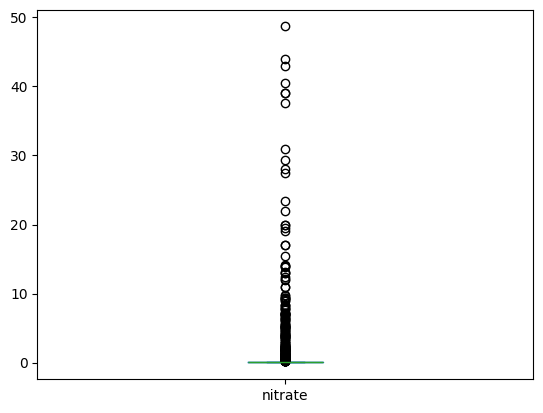

In [25]:
df[["nitrate"]].plot(kind = "box")

In [26]:
q1 = df["nitrate"].quantile(0.25)
q3 = df["nitrate"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df["nitrate"] < lower_bound) | (df["nitrate"] > upper_bound)]
print(f"Outliers found: {len(outliers)}")
# outliers

Outliers found: 211


In [27]:
top_nitrate_outliers = list(df["nitrate"].sort_values()[-20:].index)
top_nitrate_outliers
df = df.drop(top_nitrate_outliers)
len(df)

932

## Test / train split

In [28]:
# Define the split by year
train_years = list(range(2008, 2021))
test_years = [2021, 2022, 2023]

# Filter datasets
train_df = df[df["year"].isin(train_years)].copy()
test_df = df[df["year"].isin(test_years)].copy()

print(f"Train: {len(train_df)}")
print(f"Test: {len(test_df)}")

Train: 756
Test: 176


In [29]:
# n = len(df)
# train_size = int(n * 0.8)

# train_df = df.iloc[:train_size]
# test_df = df.iloc[train_size:]

# print(f"Train: {len(train_df)}")
# print(f"Test: {len(test_df)}")


In [30]:
X_train = train_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_train = train_df["nitrate"]

X_test = test_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_test = test_df["nitrate"]

## Preprocess data

In [31]:
categorical_cols = X_train.select_dtypes(include="category").columns.tolist()
cat_features_idx = [X_train.columns.get_loc(col) for col in categorical_cols]

In [32]:
# print("Categorical:", categorical_cols)
# print("Numerical:", numerical_cols)
# print("All X_train columns:", X_train.columns.tolist())

In [33]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

## Initialize model

In [34]:
param_grid = {
    "iterations": [500, 1000],
    "depth": [6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "l2_leaf_reg": [1, 3, 5],
}

In [35]:
tscv = TimeSeriesSplit(n_splits=5)

best_score = float('inf')
best_model = None
best_params = None

for i in range(20):  # Random sampling
    params = {k: np.random.choice(v) for k, v in param_grid.items()}
    fold_maes = []

    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train_log.iloc[train_idx], y_train_log.iloc[val_idx]

        model = CatBoostRegressor(
            cat_features=cat_features_idx,
            verbose=0,
            **params
        )
        model.fit(X_tr, y_tr)
        y_val_pred = model.predict(X_val)
        fold_maes.append(mean_absolute_error(y_val, y_val_pred))

    mean_mae = np.mean(fold_maes)
    if mean_mae < best_score:
        best_score = mean_mae
        best_model = model
        best_params = params

print("Best CV MAE (log-transformed):", best_score)
print("Best params:", best_params)

CatBoostError: Invalid type for cat_feature category for [feature_idx=0]=1.0 : cat_features must be integer or string, real number values and NaN values should be converted to string.

## Hyperparameter tuning

In [342]:
print("Best CV MAE:", -search.best_score_)
print("Best params:", search.best_params_)

Best CV MAE: 0.403587901196287
Best params: {'regressor__rf__n_estimators': 200, 'regressor__rf__min_samples_split': 2, 'regressor__rf__min_samples_leaf': 1, 'regressor__rf__max_features': 0.5, 'regressor__rf__max_depth': 15}


## Learning curve

In [343]:
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [344]:
n = len(X_train)

train_errors = []
val_errors = []
train_stds = []
val_stds = []

for frac in train_sizes:
    split_idx = int(frac * n)
    X_subset = X_train.iloc[:split_idx]
    y_subset = y_train.iloc[:split_idx]

    tscv = TimeSeriesSplit(n_splits=5)
    fold_train_scores = []
    fold_val_scores = []

    for train_idx, val_idx in tscv.split(X_subset):
        X_tr, X_val = X_subset.iloc[train_idx], X_subset.iloc[val_idx]
        y_tr, y_val = y_subset.iloc[train_idx], y_subset.iloc[val_idx]

        model = clone(best_model)
        model.fit(X_tr, y_tr)

        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)

        fold_train_scores.append(mean_absolute_error(y_tr, y_tr_pred))
        fold_val_scores.append(mean_absolute_error(y_val, y_val_pred))

    # Store mean and std
    train_errors.append(np.mean(fold_train_scores))
    val_errors.append(np.mean(fold_val_scores))
    train_stds.append(np.std(fold_train_scores))
    val_stds.append(np.std(fold_val_scores))

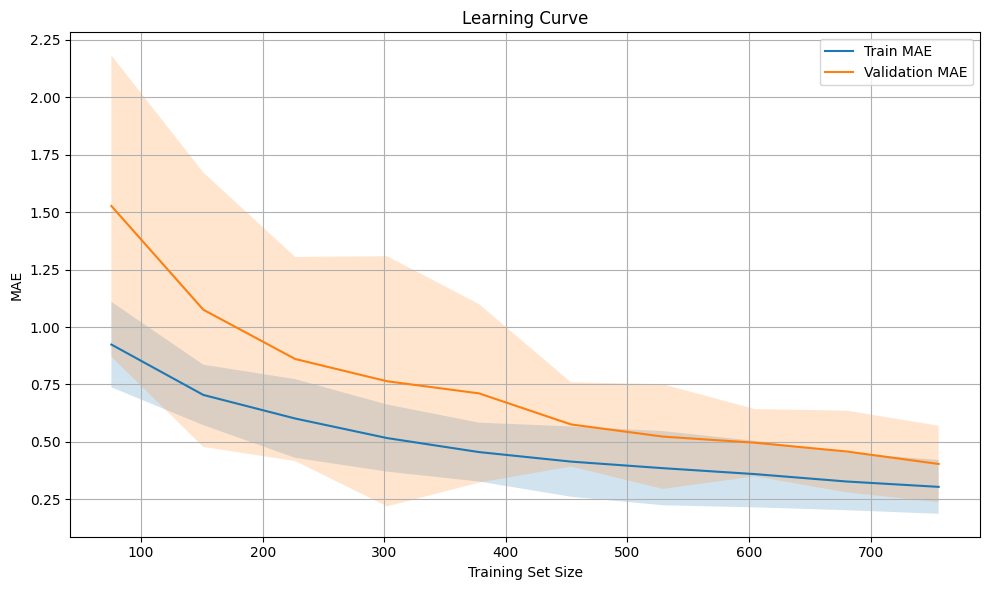

In [345]:
train_sizes_abs = train_sizes * len(X_train)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes_abs, train_errors, label="Train MAE")
plt.fill_between(train_sizes_abs, 
                 np.array(train_errors) - np.array(train_stds),
                 np.array(train_errors) + np.array(train_stds),
                 alpha=0.2)

plt.plot(train_sizes_abs, val_errors, label="Validation MAE")
plt.fill_between(train_sizes_abs, 
                 np.array(val_errors) - np.array(val_stds),
                 np.array(val_errors) + np.array(val_stds),
                 alpha=0.2)

plt.xlabel("Training Set Size")
plt.ylabel("MAE")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Train model

In [346]:
best_model = clone(best_model)
best_model.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('prep',
                                                      ColumnTransformer(transformers=[('cat_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['landuse '
                                                                                        'code',
                                                                                        'mainsoilclassification_1']),
                                                                                      ('num_scaler',
                                                                                       StandardScaler(),
                                                                                       ['population',
                                                                                        'groundwater '
                                                                                        'depth',
                                                                                        'elevation',
                                                                                        'precipitation',
                                                                                        'temperature',
                                                                                        'n '
                                                                                        'deposition',
                                                                                        'organicmattercontent_1',
                                                                                        'density_1',
                                                                                        'acidity_1'])])),
                                                     ('rf',
                                                      RandomForestRegressor(max_depth=15,
                                                                            max_features=0.5,
                                                                            n_estimators=200,
                                                                            random_state=42))]))

## Final Train score

In [347]:
pred_train = best_model.predict(X_train)

print("Train R2:", r2_score(y_train, pred_train))
print("Train MAE:", mean_absolute_error(y_train, pred_train))
print("Test RMSE:", sqrt(mean_squared_error(y_train, pred_train)))

Train R2: 0.9290453932643952
Train MAE: 0.16852734696621707
Test RMSE: 0.6047198815482722


## Final Test score

In [348]:
pred_nitrate = best_model.predict(X_test)

print("Test R2:", r2_score(y_test,  pred_nitrate))
print("Test MAE:",mean_absolute_error(y_test, pred_nitrate))
print("Test RMSE:", sqrt(mean_squared_error(y_test, pred_nitrate)))

Test R2: 0.5242532682990622
Test MAE: 0.2560732482272582
Test RMSE: 0.8364117618802135


In [349]:
pred_nitrate

array([0.05591079, 0.06668425, 0.06026846, 0.0530326 , 0.05591079,
       2.8308175 , 0.05352559, 0.06073725, 0.08633217, 4.33644099,
       0.1060931 , 0.0625055 , 0.0596908 , 0.05770765, 0.05507507,
       0.05495212, 0.5506111 , 0.05566157, 0.06618991, 0.05987307,
       0.05636549, 0.05636549, 0.19186663, 0.05589883, 0.0569253 ,
       0.05822661, 0.17144047, 0.05489653, 0.05422311, 0.06130804,
       0.06124111, 0.06130804, 0.07342117, 0.07353329, 0.06299209,
       0.05362323, 0.05274482, 0.07233521, 0.06199606, 2.15391098,
       0.07894556, 5.57739321, 0.15827614, 0.07139141, 0.05179272,
       0.14684836, 0.23928385, 0.05891809, 0.05329677, 1.54359713,
       6.55314741, 0.97384428, 1.38574885, 0.07050249, 0.19073832,
       1.04494846, 0.08137318, 0.35878719, 0.05320749, 3.41606323,
       0.05262965, 0.06464614, 0.06568327, 3.05405317, 0.21434384,
       0.06015374, 0.07260114, 0.08719626, 0.05397664, 0.09568023,
       0.06078062, 0.24780679, 1.53439443, 0.09011219, 0.06184

## Real vs Predicted

<Axes: xlabel='nitrate', ylabel='nitrate'>

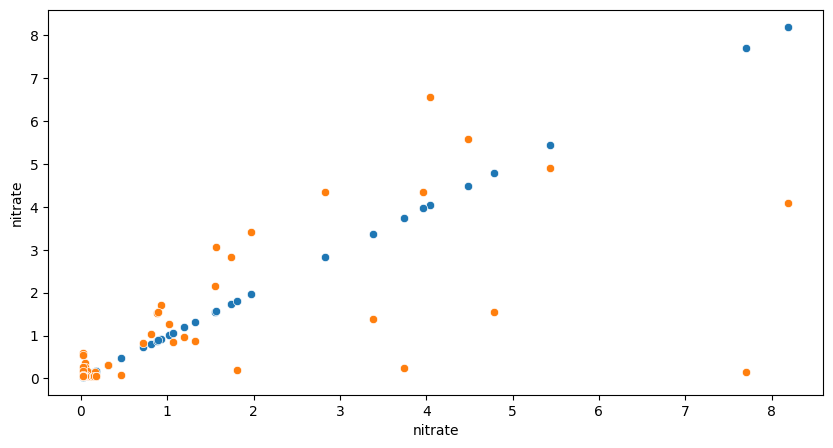

In [350]:
fix, ax = plt.subplots(figsize= (10,5))

sns.scatterplot(x = y_test, y = y_test, ax = ax)
sns.scatterplot(x = y_test, y = pred_nitrate, ax = ax)

## Residuals

Text(0, 0.5, 'Residuals')

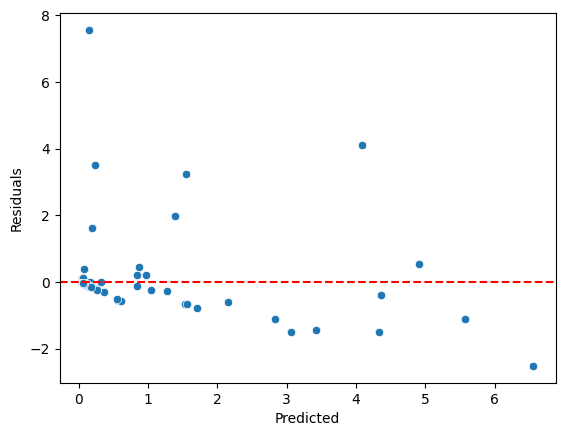

In [351]:
preds = best_model.predict(X_test)
residuals = y_test - preds
sns.scatterplot(x=preds, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted"); plt.ylabel("Residuals")

## Predictions on the map

In [352]:
coords = test_df[["lon", "lat"]].reset_index(drop=True)

print(len(coords['lon']))
print(len(coords['lat']))
print(len(np.expm1(pred_nitrate)))
print(len(np.expm1(y_test)))

176
176
176
176


In [353]:
#extract 'lon' and 'lat' from test_df
coords = test_df[["lon", "lat"]].reset_index(drop=True)

# construct new dataframe with predictions, real values and locations
gdf = gpd.GeoDataFrame({
    'lon': coords['lon'],
    'lat': coords['lat'],
    'nitrate_pred': pred_nitrate,
    'nitrate_true': y_test.reset_index(drop=True)
}, geometry=gpd.points_from_xy(coords["lon"], coords["lat"]))

gdf.crs = "EPSG:4326"

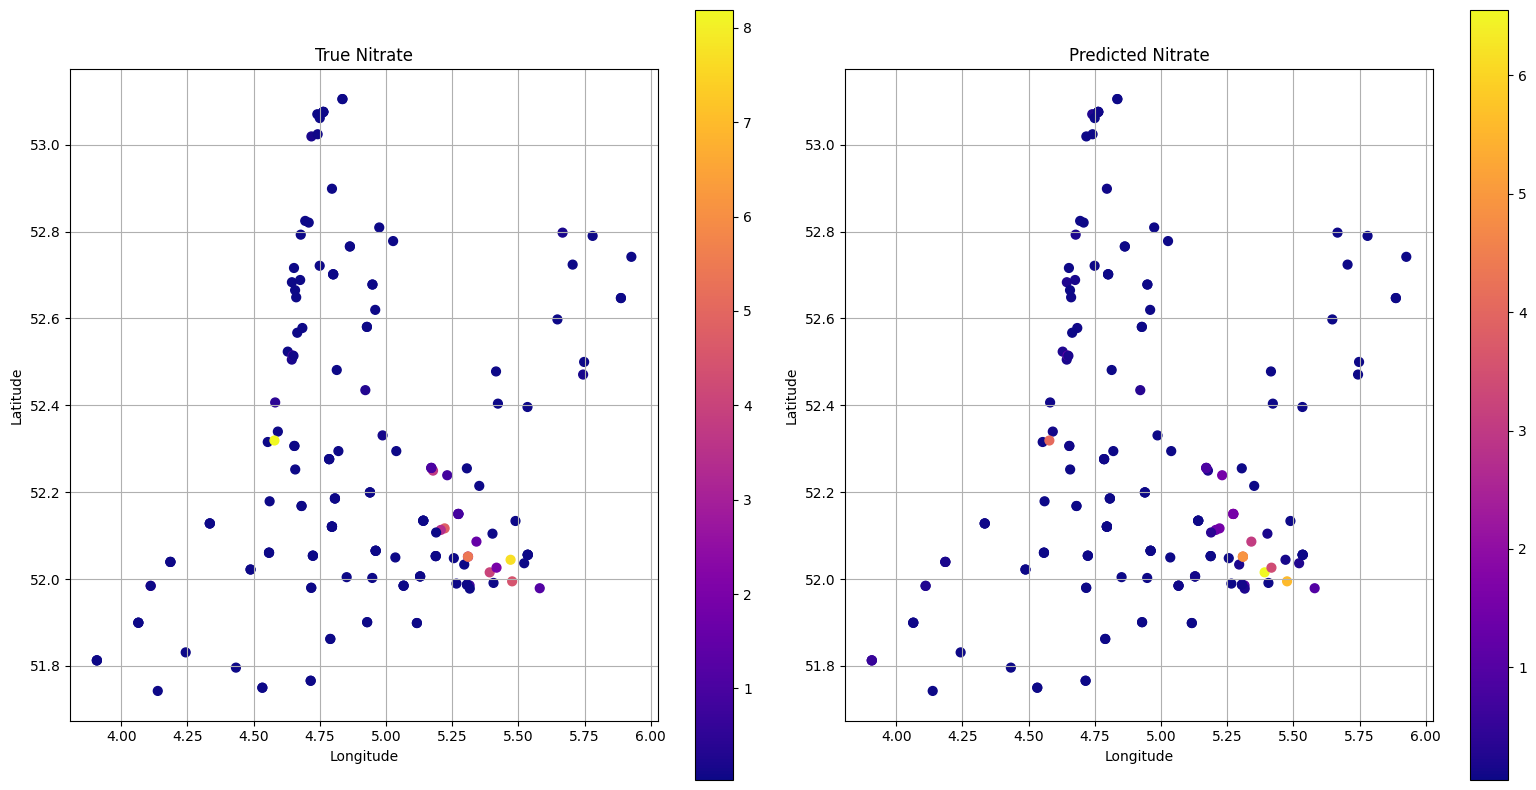

In [354]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
axs[0].set_title("True Nitrate")

gdf.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
axs[1].set_title("Predicted Nitrate")

for ax in axs:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)

plt.tight_layout()
plt.show()

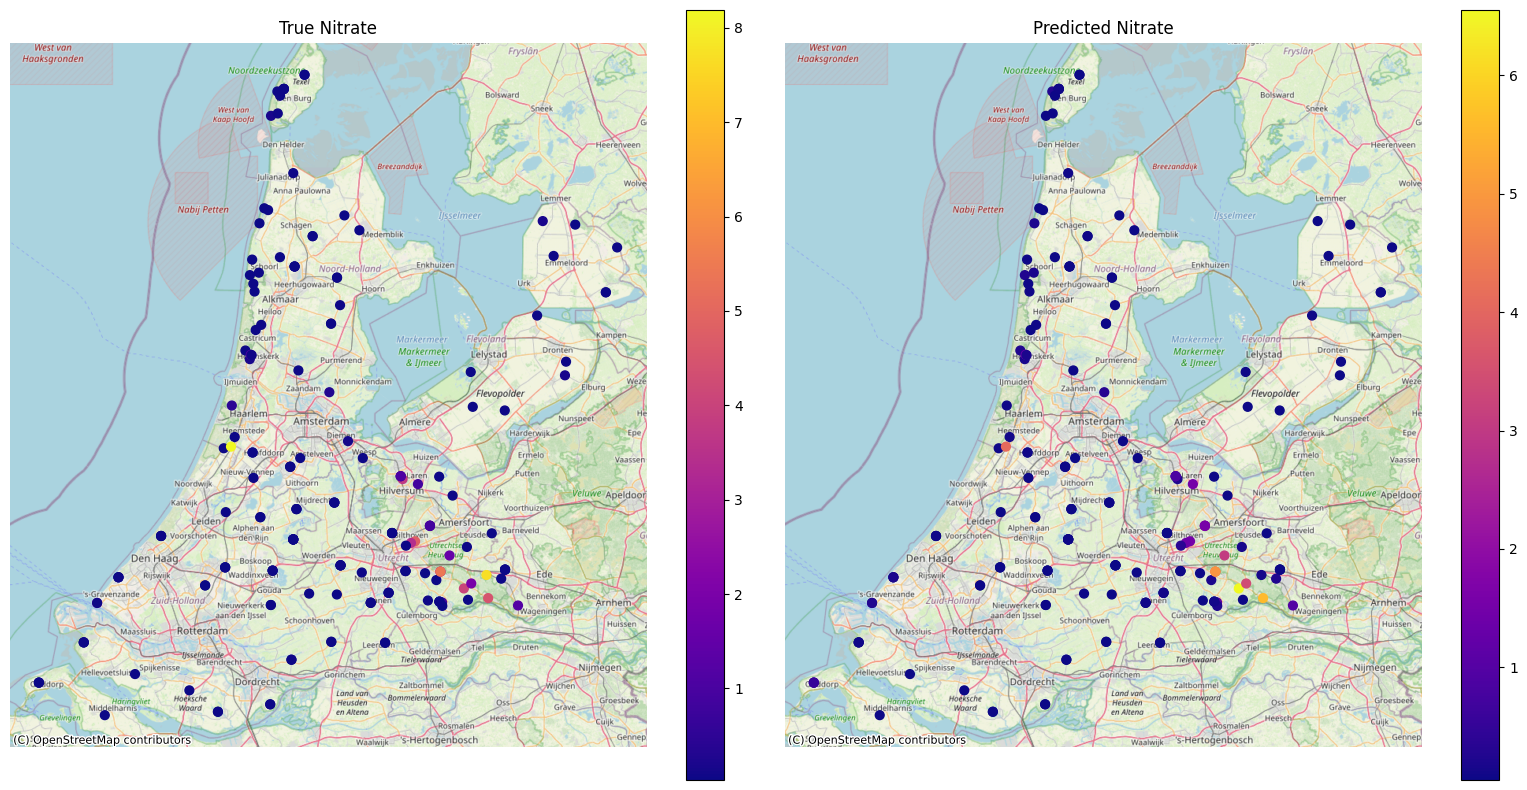

In [355]:
gdf_3857 = gdf.to_crs(epsg=3857)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf_3857.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[0], source=ctx.providers.OpenStreetMap.Mapnik)
axs[0].set_title("True Nitrate")

gdf_3857.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[1], source=ctx.providers.OpenStreetMap.Mapnik)
axs[1].set_title("Predicted Nitrate")

for ax in axs:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

## Feature importances

--> Gain (by default) how much each feature, on average, reduces the impurity (MSE or Gini)

In [356]:
best_model = clone(best_model)
best_model.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('prep',
                                                      ColumnTransformer(transformers=[('cat_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['landuse '
                                                                                        'code',
                                                                                        'mainsoilclassification_1']),
                                                                                      ('num_scaler',
                                                                                       StandardScaler(),
                                                                                       ['population',
                                                                                        'groundwater '
                                                                                        'depth',
                                                                                        'elevation',
                                                                                        'precipitation',
                                                                                        'temperature',
                                                                                        'n '
                                                                                        'deposition',
                                                                                        'organicmattercontent_1',
                                                                                        'density_1',
                                                                                        'acidity_1'])])),
                                                     ('rf',
                                                      RandomForestRegressor(max_depth=15,
                                                                            max_features=0.5,
                                                                            n_estimators=200,
                                                                            random_state=42))]))

In [357]:
if isinstance(best_model, TransformedTargetRegressor):
    print("Yes, this is a TransformedTargetRegressor.")
else:
    print("Nope, it's not.")

Yes, this is a TransformedTargetRegressor.


In [358]:
inner_pipeline = best_model.regressor_
fitted_preprocessor = inner_pipeline.named_steps['prep']
fitted_model = inner_pipeline.named_steps['rf']

feature_names = fitted_preprocessor.get_feature_names_out()

importances = fitted_model.feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df)

                                              feature    importance
50                              num_scaler__acidity_1  2.750931e-01
44                              num_scaler__elevation  1.798503e-01
43                      num_scaler__groundwater depth  1.744892e-01
47                           num_scaler__n deposition  9.286401e-02
42                             num_scaler__population  7.357271e-02
49                              num_scaler__density_1  4.296231e-02
48                 num_scaler__organicmattercontent_1  3.820210e-02
46                            num_scaler__temperature  2.610932e-02
33  cat_ohe__mainsoilclassification_1_Dikke eerdgr...  1.683569e-02
45                          num_scaler__precipitation  1.677952e-02
14                         cat_ohe__landuse code_22.0  1.100241e-02
16                         cat_ohe__landuse code_25.0  9.296008e-03
36  cat_ohe__mainsoilclassification_1_Kalkloze zan...  6.488551e-03
31                         cat_ohe__landuse code

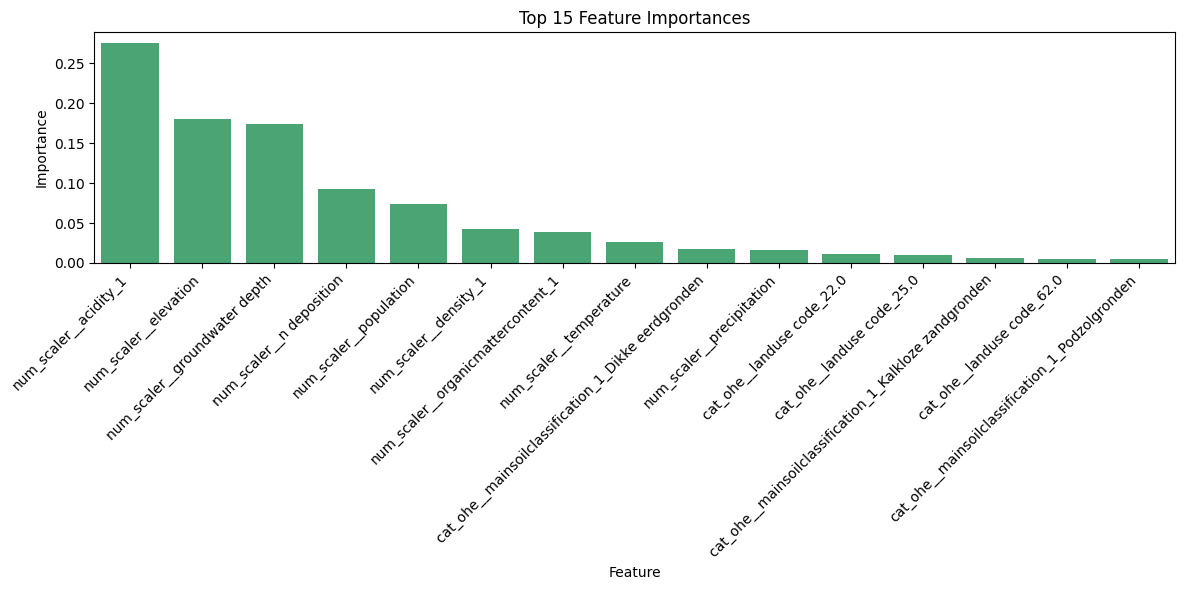

In [359]:
# Build and plot the importance DataFrame
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x="Feature", y="Importance", data=fi_df.head(15), color="mediumseagreen")
plt.xticks(rotation=45, ha='right')
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()


In [360]:
# --- Keep:
# organiccontent
# elevation
# soil code
# acidity
# groundwater depth
# density
# population
# precipitation
# n_deposition
# temperature

# --- Remove:
# landuse
# soil region
# month